## Libraries

In [ ]:
%pip install gymnasium
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

In [17]:
import os
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
%matplotlib inline

In [18]:
import torch
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from pytorch_lightning import LightningModule, Trainer

## Environment

In [19]:
import cv2
from gymnasium.core import ObservationWrapper
from gymnasium.spaces import Box
import matplotlib.pyplot as plt

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (1, self.img_size[0], self.img_size[1]))

    def observation(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = img[57:-17, 6:-6]
        img = cv2.resize(img, self.img_size)
        img = img[np.newaxis,...]
        return img

In [20]:
from gymnasium.spaces.box import Box
from gymnasium.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        n_channels, height, width = env.observation_space.shape
        obs_shape = [n_channels * n_frames, height, width]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset()[0])
        return self.framebuffer
    
    def step(self, action):
        new_img, reward, done, info, _ = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        offset = self.env.observation_space.shape[0]
        axis = 0
        cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [21]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

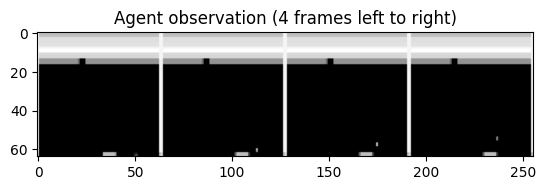

In [22]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.title("Agent observation (4 frames left to right)")
plt.imshow(rearrange(obs, 'n h w -> h (n w)'), 'gray');

## Replay buffer

In [23]:
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [24]:
class ReplayDataset(IterableDataset):
    
    def __init__(self, replay, batch_size):
        self.replay = replay
        self.batch_size = batch_size
        
    def __iter__(self):
        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)
        for data in zip(states, actions, rewards, next_states, dones):
            yield data

## Agent

In [25]:
class Network(nn.Module):

    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(obs_size[0], 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

In [26]:
class DQNAgent(LightningModule):
    
    def __init__(self, state_shape, n_actions, epsilon=0.5, gamma=0.99, buffer_size=10**5, 
                 populate_steps=10_000, batch_size=512, max_steps=10_000):
        super().__init__()
        self.save_hyperparameters()
        
        self.env = make_env()
        self.buffer = ReplayBuffer(buffer_size)
        self.state = self.env.reset()
        self.episode_reward = 0
        self.total_reward = 0
        
        self.model = Network(state_shape, self.hparams.n_actions)
        self.target_model = Network(state_shape, self.hparams.n_actions)
        
        self.populate()
        
    def populate(self):
        for _ in range(self.hparams.populate_steps):
            self.play_step()
        self.state = self.env.reset()
        
    def get_action(self, state, device):
        if random.random() < self.hparams.epsilon:
            return self.get_random_action()
        else:
            return self.get_best_action(state, device)
        
    def get_best_action(self, state, device):
        state = torch.tensor([state], device=device).float()
        qvalues = self.model(state)[0]
        best_action = torch.argmax(qvalues)
        return best_action.item()
   
    def get_random_action(self):
        return random.randint(0, self.hparams.n_actions-1)
    
    def update_epsilon(self):
        self.hparams.epsilon = max(self.hparams.epsilon * 0.99, 0.02)
    
    def copy_weights(self):
        self.model.load_state_dict(self.target_model.state_dict())
        
    def calculate_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = states.float()
        rewards = rewards.float()
        next_states = next_states.float()
        
        state_action_values = self.target_model(states).gather(1, actions.long().unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.model(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.hparams.gamma + rewards
        return nn.MSELoss()(state_action_values, expected_state_action_values)
    
    def play_step(self, device='cpu'):
        action = self.get_action(self.state, device)
        s_next, r, done, _ = self.env.step(action)
        self.buffer.add(self.state, action, r, s_next, done)
        self.state = s_next
        if done:
            self.state = self.env.reset()
        return r, done
    
    def training_step(self, batch, batch_no):
        device = self.get_device(batch)
        
        for _ in range(10):
            reward, done = self.play_step(device)
            self.episode_reward += reward
            
            if done:
                self.total_reward = self.episode_reward
                self.episode_reward = 0
        
        loss = self.calculate_loss(batch)
        
        if self.global_step % 500 == 0:
            self.copy_weights()
            self.update_epsilon()
            
        self.log('epsilon', self.hparams.epsilon)
        self.log('total_reward', self.total_reward)
        self.log('buffer_size', len(self.buffer))
        self.log('loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = Adam(self.target_model.parameters(), lr=0.0001)
        return optimizer

    def train_dataloader(self):
        dataset = ReplayDataset(self.buffer, self.hparams.batch_size)
        dataloader = DataLoader(dataset=dataset, batch_size=self.hparams.batch_size)
        return dataloader
    
    def get_device(self, batch):
        return batch[0].device.index if self.on_gpu else "cpu"

## Training

In [27]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.6, batch_size=256)

trainer = Trainer(
    accelerator="gpu",
    max_epochs=-1,
    enable_progress_bar=True,
)

trainer.fit(agent)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | model        | Network | 827 K 
1 | target_model | Network | 827 K 
-----------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.623     Total estimated model params size (MB)


Epoch 177745: : 0it [00:00, ?it/s, v_num=34]    

## Metrics from tensorboard

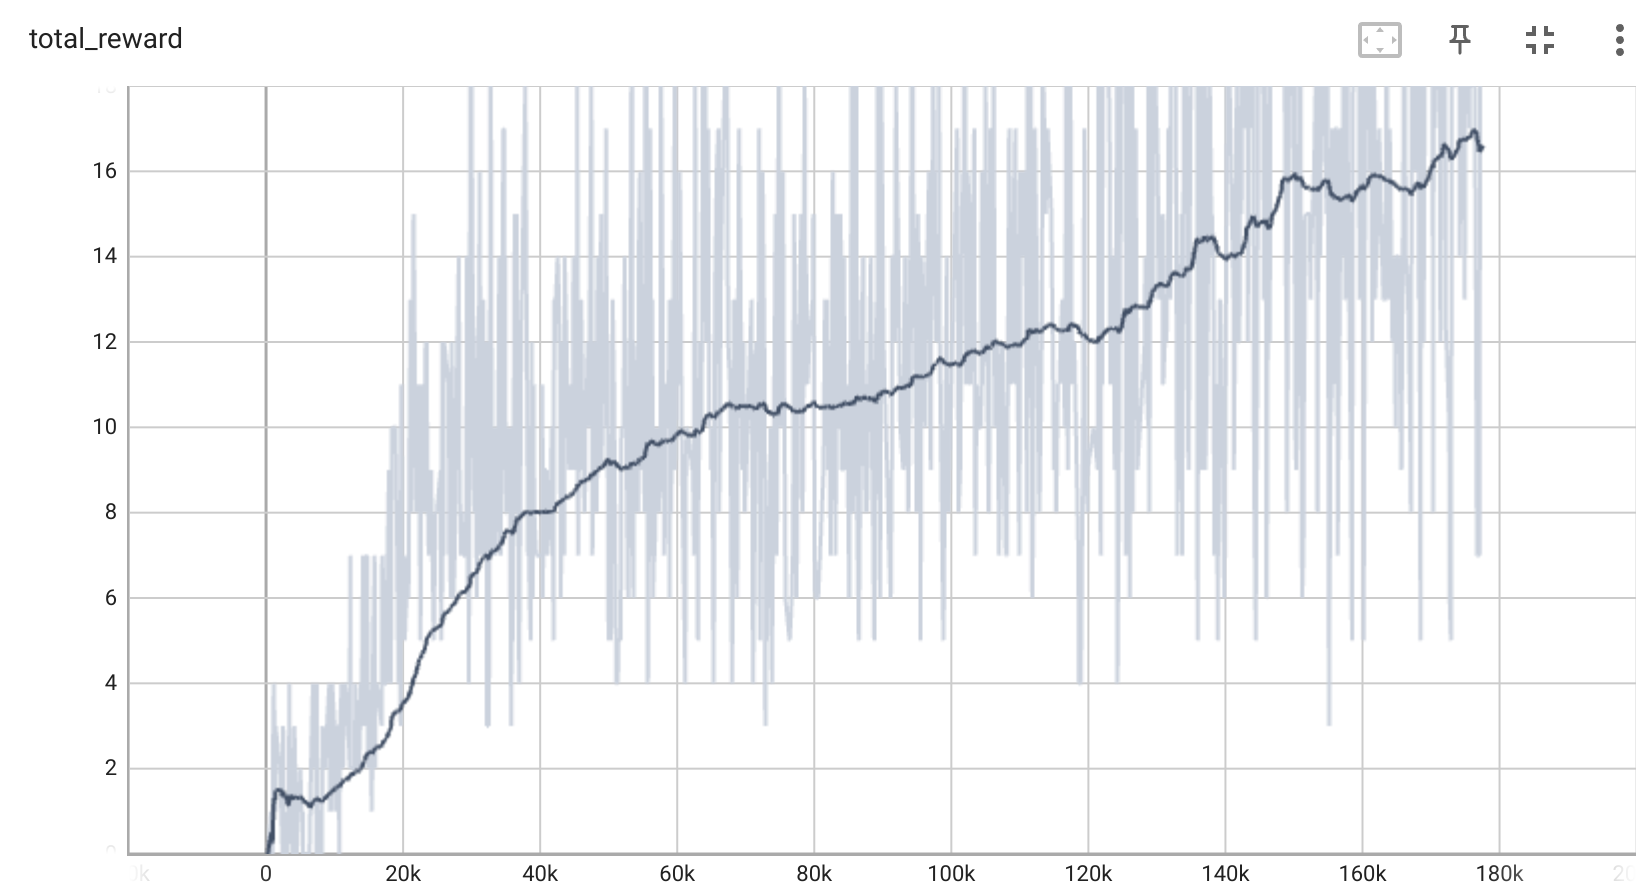

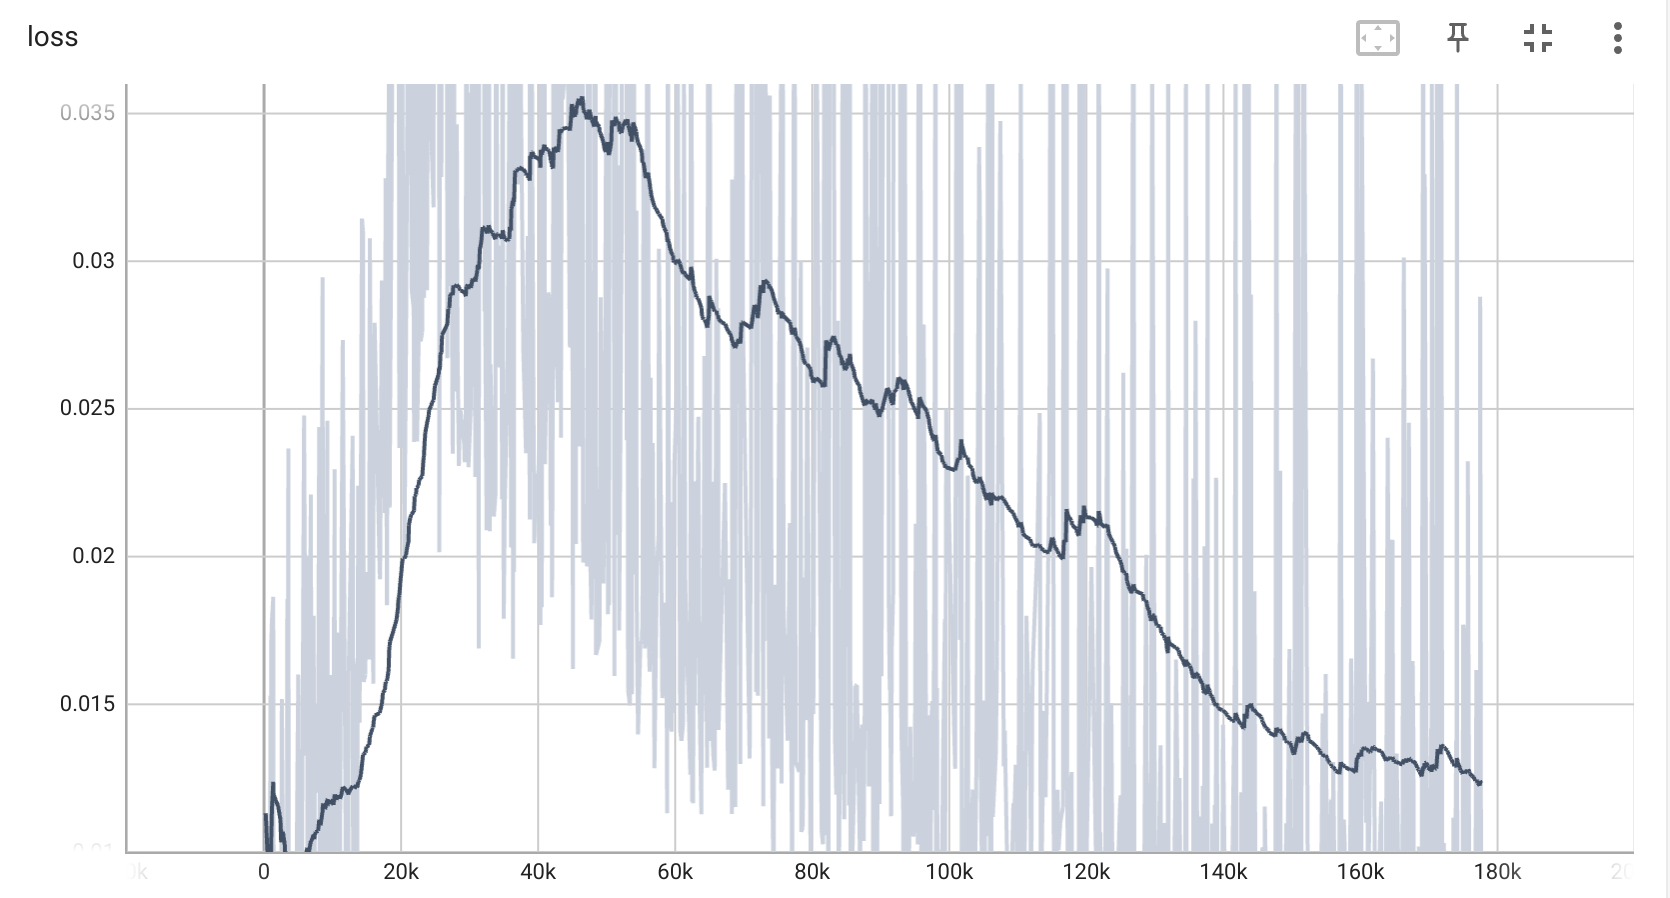